In [ ]:
# Please do not edit this cell.
# Imports
import os, random, time, math, json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
ROOT = os.path.join(os.getcwd(), "data/")

TRAIN_DIR = os.path.join(ROOT, "Training")
TEST_DIR  = os.path.join(ROOT, "Testing")
CLASS_NAMES = ["glioma", "notumor"]  # expected two folders inside both training/ and testing/

import requests
import os
import zipfile
import shutil

os.makedirs(ROOT, exist_ok=True)

def dataset_already_downloaded(root, train_dir, test_dir, class_names):
    if not (os.path.isdir(train_dir) and os.path.isdir(test_dir)):
        return False
    for base in (train_dir, test_dir):
        for cname in class_names:
            if not os.path.isdir(os.path.join(base, cname)):
                return False
    return True

if dataset_already_downloaded(ROOT, TRAIN_DIR, TEST_DIR, CLASS_NAMES):
    print("Dataset already downloaded and unzipped.")
else:
    zip_url = "https://github.com/YData123/sds365-fa25/raw/refs/heads/main/assignments/assn2/kaggle-MRI.zip"
    zip_filename = "kaggle-MRI.zip"
    destination_zip_path = os.path.join(ROOT, zip_filename)

    print(f"Downloading {zip_filename}...")
    response = requests.get(zip_url, stream=True)
    response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
    with open(destination_zip_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"Downloaded {zip_filename} to {destination_zip_path}")

    print(f"Unzipping {destination_zip_path}...")
    with zipfile.ZipFile(destination_zip_path, 'r') as zip_ref:
        zip_ref.extractall(ROOT)
    full_extracted_path = ROOT + zip_filename.split('.')[0]
    for item in os.listdir(full_extracted_path):
        s = os.path.join(full_extracted_path, item)
        d = os.path.join(ROOT, item)
        # Move item to ROOT
        shutil.move(s, d)

    # Remove the now empty extracted subfolder
    print(f"Removing empty folder {full_extracted_path}...")
    shutil.rmtree(full_extracted_path)
    os.remove(destination_zip_path)
    print("Cleanup complete.")

    print(f"Successfully unzipped content to {ROOT}")

# Validation of directory structure
def assert_dir(p):
    if not os.path.isdir(p):
        raise FileNotFoundError(f"Expected directory not found: {p}")

assert_dir(ROOT)
assert_dir(TRAIN_DIR)
assert_dir(TEST_DIR)

# Load image as grayscale for consistent viewing
def load_img_gray(path):
    img = Image.open(path).convert("L")  # force grayscale
    return img

# List image files in a folder
def count_images(folder):
    exts = ("*.jpg", "*.jpeg")
    files = []
    for e in exts:
        files.extend(glob(os.path.join(folder, e)))
    return sorted(files)

Dataset already downloaded and unzipped.


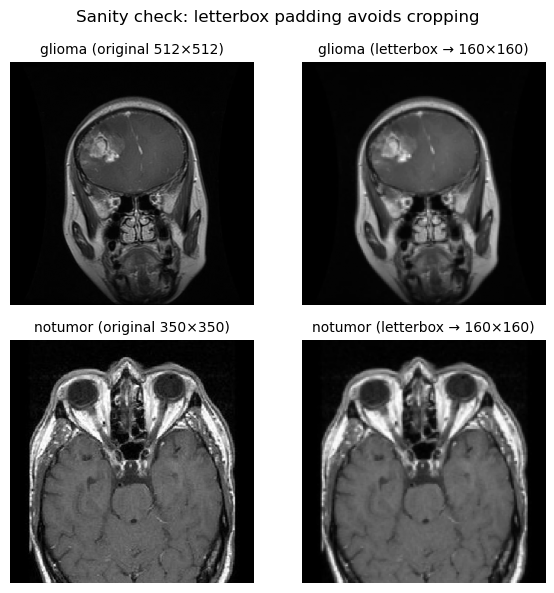

In [3]:
# Helper functions: letterbox pad to square (no cropping) + resize to 160x160

IMG_SIZE = 160  # target size used throughout the assignment

def letterbox_to_square(img: Image.Image, fill=0) -> Image.Image:
    """
    Pads the image to a square using 'fill' (black), centered, without distortion.
    Keeps original content intact (no cropping).
    """
    if img.mode not in ("L", "RGB"):
        img = img.convert("L")
    w, h = img.size
    s = max(w, h)
    canvas = Image.new(img.mode, (s, s), color=fill)
    canvas.paste(img, ((s - w)//2, (s - h)//2))
    return canvas

def preprocess_image(img: Image.Image, size: int = IMG_SIZE) -> Image.Image:
    """Letterbox pad -> resize to (size, size)."""
    sq = letterbox_to_square(img, fill=0)
    return sq.resize((size, size), resample=Image.BILINEAR)

# Visualize ORIGINAL vs PREPROCESSED (letterboxed) for first training image of each class
fig, axes = plt.subplots(len(CLASS_NAMES), 2, figsize=(6, 3*len(CLASS_NAMES)))
if len(CLASS_NAMES) == 1:
    axes = np.array([axes])  # ensure 2D array indexing

for i, c in enumerate(CLASS_NAMES):
    class_dir = os.path.join(TRAIN_DIR, c)
    files = count_images(class_dir)
    ax_orig, ax_proc = axes[i, 0], axes[i, 1]
    if not files:
        ax_orig.axis("off"); ax_proc.axis("off")
        ax_proc.set_title(f"No images found for {c}")
        continue

    p = files[0]
    img = load_img_gray(p)            # original grayscale
    proc = preprocess_image(img)      # padded + resized 160x160

    ax_orig.imshow(img, cmap="gray");  ax_orig.axis("off")
    ax_orig.set_title(f"{c} (original {img.size[0]}×{img.size[1]})", fontsize=10)

    ax_proc.imshow(proc, cmap="gray"); ax_proc.axis("off")
    ax_proc.set_title(f"{c} (letterbox → {IMG_SIZE}×{IMG_SIZE})", fontsize=10)

plt.suptitle("Sanity check: letterbox padding avoids cropping", fontsize=12)
plt.tight_layout()
plt.show()

In [4]:
# Gather file paths & labels; split TRAIN into train/validation (TEST untouched)

def list_images_with_labels(root_dir, classes):
    paths, labels = [], []
    for ci, cname in enumerate(classes):
        cdir = os.path.join(root_dir, cname)
        for p in count_images(cdir):
            paths.append(p); labels.append(ci)
    return np.array(paths), np.array(labels)

# load TRAIN and TEST file lists
train_paths, train_labels = list_images_with_labels(TRAIN_DIR, CLASS_NAMES)
test_paths,  test_labels  = list_images_with_labels(TEST_DIR,  CLASS_NAMES)

# stratified split of TRAIN -> (train, val)
VAL_FRACTION = 0.20
tr_paths, val_paths, tr_labels, val_labels = train_test_split(
    train_paths, train_labels,
    test_size=VAL_FRACTION,
    random_state=42,
    stratify=train_labels
)

print(f"Counts -> train: {len(tr_paths)}, val: {len(val_paths)}, test: {len(test_paths)}")

Counts -> train: 2332, val: 584, test: 705


In [6]:
# PyTorch input pipeline with the SAME preprocessing:
# grayscale -> letterbox to square (no crop) -> resize to IMG_SIZE -> per-image z-score


# ensure IMG_SIZE is available if cell run standalone
if 'IMG_SIZE' not in globals():
    IMG_SIZE = 160

def pil_letterbox_resize(img, target=IMG_SIZE, fill=0):
    if img.mode not in ("L", "RGB"):
        img = img.convert("L")
    w, h = img.size
    s = max(w, h)
    canvas = Image.new(img.mode, (s, s), color=fill)
    canvas.paste(img, ((s - w)//2, (s - h)//2))
    return canvas.resize((target, target), resample=Image.BILINEAR)

# per-image z-score normalization for a tensor CxHxW
def per_image_zscore_tensor(t):
    mean = t.mean()
    std = t.std()
    return (t - mean) / t.std().clamp(min=1e-6)

train_transform = T.Compose([
    T.Lambda(lambda img: pil_letterbox_resize(img, target=IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.10, contrast=(0.9, 1.1)),
    T.ToTensor(),
    T.Lambda(lambda t: (t - t.mean()) / t.std().clamp(min=1e-6)),
])

val_transform = T.Compose([
    T.Lambda(lambda img: pil_letterbox_resize(img, target=IMG_SIZE)),
    T.ToTensor(),
    T.Lambda(lambda t: (t - t.mean()) / t.std().clamp(min=1e-6)),
])

class MRIDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = np.array(paths)
        self.labels = np.array(labels).astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        lbl = self.labels[idx]
        img = Image.open(p).convert("L")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor([lbl], dtype=torch.float32)

BATCH_SIZE = 16
train_ds = MRIDataset(tr_paths, tr_labels, transform=train_transform)
val_ds = MRIDataset(val_paths, val_labels, transform=val_transform)
test_ds = MRIDataset(test_paths, test_labels, transform=val_transform)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

xb, yb = next(iter(train_loader))
print("Train batch:", xb.shape, yb.shape)

Train batch: torch.Size([16, 1, 160, 160]) torch.Size([16, 1])


/tmp/ipykernel_1520918/2587579078.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c = int(yb[i])


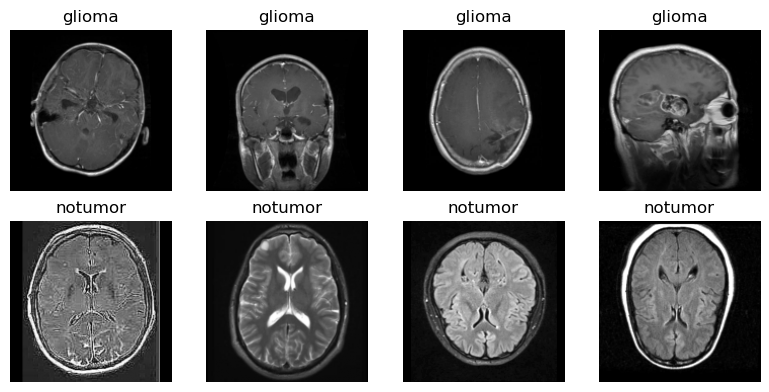

In [7]:
# Quick visual sanity check: Show 4 preprocessed samples per class from the TRAIN pipeline
class_names = CLASS_NAMES

# collect a small batch
xb, yb = next(iter(train_loader))
xb = xb.numpy(); yb = yb.numpy()

fig, axes = plt.subplots(2, 4, figsize=(8,4))
axes = axes.reshape(-1)
shown = {i:0 for i in range(len(class_names))}
for i in range(len(xb)):
    c = int(yb[i])
    if shown[c] >= 4:
        continue
    axes[c*4 + shown[c]].imshow(xb[i,0,:, :], cmap="gray")
    axes[c*4 + shown[c]].axis("off")
    axes[c*4 + shown[c]].set_title(class_names[c])
    shown[c]+=1
    if all(v==4 for v in shown.values()):
        break
plt.tight_layout(); plt.show()

In [8]:
class MCDropout(nn.Dropout):
    """Dropout that always samples masks (training=True) so MC passes work in eval mode."""
    def forward(self, input):
        return F.dropout(input, p=self.p, training=True, inplace=self.inplace)

class MCSpatialDropout2d(nn.Dropout2d):
    """Spatial (channel) dropout that always samples masks (training=True)."""
    def forward(self, input):
        return F.dropout2d(input, p=self.p, training=True, inplace=self.inplace)

def build_cnn(dilated=False, in_channels=1, num_classes=1, drop_rate=0.20, use_mc_dropout=True, use_spatial=True):
    """
    PyTorch version of the provided Keras model.
    - dilated: if True uses dilation rates (2,3,5) for the 2nd conv in each block.
    - use_mc_dropout/use_spatial select which Dropout class to use for conv outputs.
    """
    rates = (2, 3, 5) if dilated else (1, 1, 1)

    if use_mc_dropout and use_spatial:
        DropConv = MCSpatialDropout2d
    elif use_spatial:
        DropConv = nn.Dropout2d
    elif use_mc_dropout:
        DropConv = MCDropout
    else:
        DropConv = nn.Dropout

    class TinyCNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.blockA = nn.Sequential(
                nn.Conv2d(in_channels, 32, 3, padding=1, dilation=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(32),
                nn.Conv2d(32, 32, 3, padding=rates[0], dilation=rates[0]),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2),
                DropConv(drop_rate)
            )
            self.blockB = nn.Sequential(
                nn.Conv2d(32, 64, 3, padding=1, dilation=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(64),
                nn.Conv2d(64, 64, 3, padding=rates[1], dilation=rates[1]),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(64),
                nn.MaxPool2d(2),
                DropConv(drop_rate)
            )
            self.blockC = nn.Sequential(
                nn.Conv2d(64, 128, 3, padding=1, dilation=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(128),
                nn.Conv2d(128, 128, 3, padding=rates[2], dilation=rates[2]),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(128),
                DropConv(drop_rate)
            )
            self.gap = nn.AdaptiveAvgPool2d(1)  # global avg pool
            self.head_dropout = nn.Dropout(drop_rate)  # standard dropout at dense head
            self.fc = nn.Linear(128, num_classes)

        def forward(self, x):
            x = self.blockA(x)
            x = self.blockB(x)
            x = self.blockC(x)
            x = self.gap(x)               # -> (N, 128, 1, 1)
            x = x.view(x.size(0), -1)     # -> (N, 128)
            x = self.head_dropout(x)
            x = self.fc(x)
            if num_classes == 1:
                return torch.sigmoid(x)
            return x

    return TinyCNN()

# example instantiation + quick print
model_base = build_cnn(dilated=True)
print(model_base)

TinyCNN(
  (blockA): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): MCSpatialDropout2d(p=0.2, inplace=False)
  )
  (blockB): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), dilation=(3, 3))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [9]:
EPOCHS = 20
OUTDIR = os.path.join(ROOT, "outputs_cnn_dilated")
os.makedirs(OUTDIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compile_model(model):
    """Setup model with optimizer and loss function"""
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=3e-5)
    criterion = nn.BCELoss()  # Binary Cross Entropy (expects probabilities, not logits)
    return model, optimizer, criterion

def train_model(model, optimizer, criterion, name, train_loader, val_loader, epochs=EPOCHS):
    ckpt = os.path.join(OUTDIR, f"{name}.pth")  # best checkpoint
    best_val_acc = 0.0
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    t0 = time.time()
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).float().view(-1, 1)
            
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * xb.size(0)
            preds = (outputs >= 0.5).float()
            train_correct += (preds == yb).sum().item()
            train_total += yb.size(0)
        
        train_loss /= train_total
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE).float().view(-1, 1)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                
                val_loss += loss.item() * xb.size(0)
                preds = (outputs >= 0.5).float()
                val_correct += (preds == yb).sum().item()
                val_total += yb.size(0)
        
        val_loss /= val_total
        val_acc = val_correct / val_total
        
        # Save history
        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.4f} - "
              f"val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_acc,
            }, ckpt)
            print(f"Saved best model with val_accuracy: {val_acc:.4f}")
    
    train_seconds = time.time() - t0
    print(f"[TIMER] {name}: training wall-clock = {train_seconds:.2f} sec "
          f"({train_seconds/max(1, len(history['loss'])):.2f} sec/epoch) (monitoring val_accuracy)")
    
    # Save final weights separately
    final_path = os.path.join(OUTDIR, f"{name}_final.pth")
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, final_path)
    
    return ckpt, history, train_seconds

def evaluate_and_report(model, loader, class_names):
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            probs = model(xb).cpu().numpy().reshape(-1)
            preds = (probs >= 0.5).astype(int)
            yt = yb.numpy().reshape(-1).astype(int)
            y_true.append(yt)
            y_pred.append(preds)
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    
    return y_true, y_pred

def measure_eval_time(model, criterion, loader, n_samples):
    model.eval()
    
    # Evaluate timing
    t0 = time.time()
    total_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).float().view(-1, 1)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            
            total_loss += loss.item() * xb.size(0)
            preds = (outputs >= 0.5).float()
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    
    eval_seconds = time.time() - t0
    loss = total_loss / total
    acc = correct / total
    print(f"[TIMER] evaluate: {eval_seconds:.2f} sec")
    
    # Predict timing
    t1 = time.time()
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(DEVICE)
            _ = model(xb)
    
    pred_seconds = time.time() - t1
    ips = n_samples / pred_seconds if pred_seconds > 0 else float("inf")
    print(f"[TIMER] predict : {pred_seconds:.2f} sec  (~{ips:.1f} images/sec)")
    
    return loss, acc, eval_seconds, pred_seconds, ips

# --- compile
model_base, optimizer_base, criterion_base = compile_model(model_base)

# --- train with validation (no test leakage)
ckpt_base, hist_base, train_time_base = train_model(
    model_base, optimizer_base, criterion_base, "dilated_cnn", 
    train_loader, val_loader, epochs=EPOCHS
)

# --- reload best and evaluate on TEST (timed)
checkpoint = torch.load(ckpt_base)
model_base.load_state_dict(checkpoint['model_state_dict'])

print("\n[TEST] Dilated:")
y_true_base, y_pred_base = evaluate_and_report(model_base, test_loader, CLASS_NAMES)
loss_b, acc_b, eval_t_b, pred_t_b, ips_b = measure_eval_time(
    model_base, criterion_base, test_loader, n_samples=len(test_paths)
)

print(f"\n[TEST] Dilated -> loss: {loss_b:.4f} | acc: {acc_b:.4f}")

Epoch 1/20 - loss: 0.5507 - accuracy: 0.7251 - val_loss: 0.4678 - val_accuracy: 0.7962
Saved best model with val_accuracy: 0.7962
Epoch 2/20 - loss: 0.4262 - accuracy: 0.8199 - val_loss: 0.3778 - val_accuracy: 0.8510
Saved best model with val_accuracy: 0.8510
Epoch 3/20 - loss: 0.3605 - accuracy: 0.8491 - val_loss: 0.3021 - val_accuracy: 0.8904
Saved best model with val_accuracy: 0.8904
Epoch 4/20 - loss: 0.3019 - accuracy: 0.8804 - val_loss: 0.2724 - val_accuracy: 0.8904
Epoch 5/20 - loss: 0.2742 - accuracy: 0.8928 - val_loss: 0.2675 - val_accuracy: 0.8938
Saved best model with val_accuracy: 0.8938
Epoch 6/20 - loss: 0.2567 - accuracy: 0.9057 - val_loss: 0.2374 - val_accuracy: 0.9110
Saved best model with val_accuracy: 0.9110
Epoch 7/20 - loss: 0.2361 - accuracy: 0.9108 - val_loss: 0.2087 - val_accuracy: 0.9161
Saved best model with val_accuracy: 0.9161
Epoch 8/20 - loss: 0.2111 - accuracy: 0.9168 - val_loss: 0.1837 - val_accuracy: 0.9315
Saved best model with val_accuracy: 0.9315
Epo

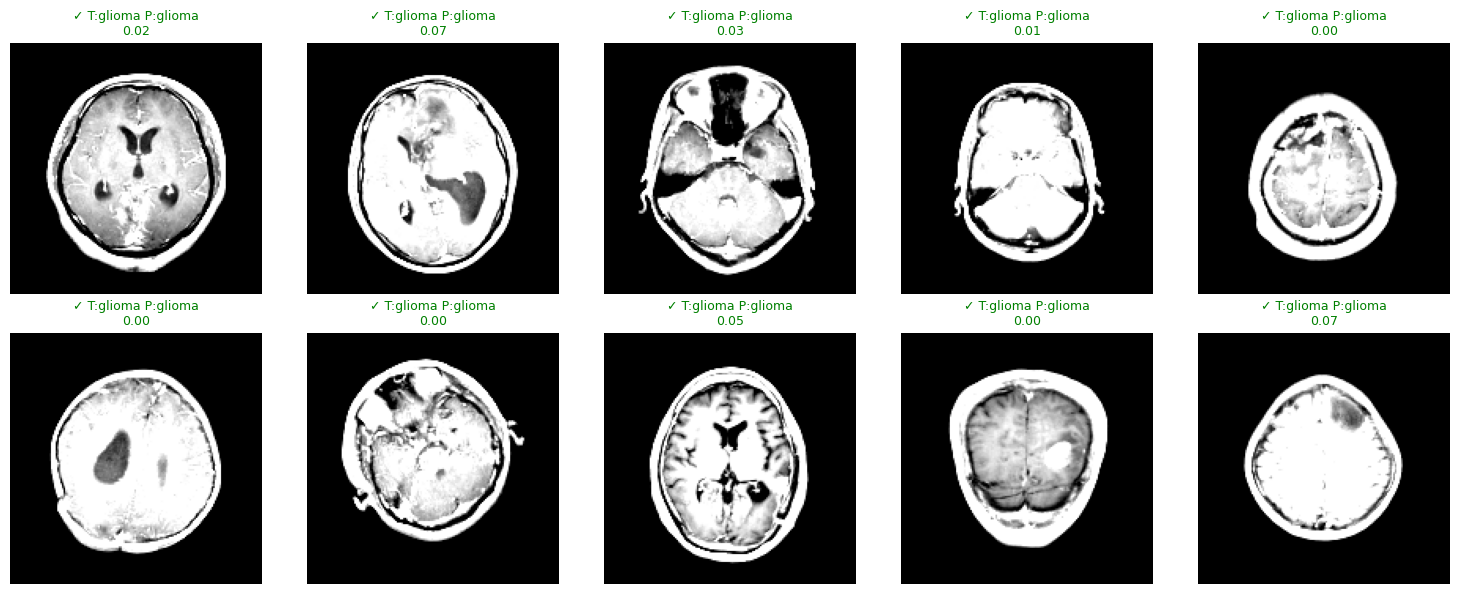

In [10]:
def quick_visualize(model, loader, class_names, n_samples=10):
    """Quick visualization of mixed correct/incorrect predictions"""
    model.eval()
    samples = []
    
    with torch.no_grad():
        for xb, yb in loader:
            xb_device = xb.to(DEVICE)
            probs = model(xb_device).cpu().numpy().reshape(-1)
            preds = (probs >= 0.5).astype(int)
            yt = yb.numpy().reshape(-1).astype(int)
            
            for i in range(len(xb)):
                samples.append({
                    'image': xb[i].cpu().numpy().transpose(1, 2, 0),
                    'true': yt[i],
                    'pred': preds[i],
                    'prob': probs[i],
                    'correct': preds[i] == yt[i]
                })
            
            if len(samples) >= n_samples * 2:
                break
    
    # Select random samples
    selected = random.sample(samples, min(n_samples, len(samples)))
    
    # Plot
    cols = 5
    rows = (len(selected) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten() if n_samples > 1 else [axes]
    
    for idx, sample in enumerate(selected):
        img = np.clip(sample['image'], 0, 1)
        if img.shape[2] == 1:
            axes[idx].imshow(img.squeeze(), cmap='gray')
        else:
            axes[idx].imshow(img)
        
        symbol = '✓' if sample['correct'] else '✗'
        color = 'green' if sample['correct'] else 'red'
        title = f"{symbol} T:{class_names[sample['true']]} P:{class_names[sample['pred']]}\n{sample['prob']:.2f}"
        axes[idx].set_title(title, color=color, fontsize=9)
        axes[idx].axis('off')
    
    for idx in range(len(selected), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Quick usage:
quick_visualize(model_base, test_loader, CLASS_NAMES, n_samples=10)